## Unsupervised Outlier Detection

1. Detect anomalies on seperate 3 seperate datasets 
    - Use different anomaly thresholds (1% -5%) 
    - And compare/verify similar dates and relationship 
    - Create a ranking/voting system for "popular" anomaly dates 
    - Additionally use Leave-one out method
2. Same but merge 3 datasets 
3. Create labels from anomalies and run supervised models
4. Optimization
5. Build a website 

https://towardsdatascience.com/in-12-minutes-stocks-analysis-with-pandas-and-scikit-learn-a8d8a7b50ee7
https://stackoverflow.com/questions/47211866/how-to-mark-specific-data-points-in-matplotlib-graph

In [22]:
import warnings
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

# Import all models
import sklearn
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loci import LOCI
from pyod.models.lscp import LSCP
from pyod.models.mcd import MCD
from pyod.models.mo_gaal import MO_GAAL
from pyod.models.ocsvm import OCSVM
from pyod.models.sos import SOS
from pyod.models.vae import VAE
# from pyod.models.xgbod import XGBOD 

from scipy import stats
pd.options.display.max_rows = 365

## Test on each Dataset Seperetly 

### Price Dataset

In [23]:
price = pd.read_csv('btc_preprocessed.csv', index_col = 0)
# apply X and standerdize 
def scale(df):
    cols = df.columns
    index = df.index
    scaler = MinMaxScaler()
    X = scaler.fit_transform(df)
    X = pd.DataFrame(X)
    X.columns = cols
    X = X.set_index(index)
    return X
X = scale(price)
print(X.columns)
X.describe()

Index(['close', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'CCI',
       'ichimoku_leadSpanA', 'ichimoku_leadSpanB', 'MACD', 'MACD_diff',
       'MACD_signal', 'AwesomeOscillator', 'KAMA', 'RateofChange', 'RSI_7',
       'RSI_14', 'StochasticOscillator', 'stoch_signal', 'TrueStrenghtIndex',
       'UltimateOscilator', 'williamsR', 'Accum_Distrubution', 'ForceIndex',
       'AvgTrueRange', 'BollingerHighBand', 'BHB_indicator',
       'BollingerLowBand', 'BLB_indicator', 'BC_middleBand', 'BC_percBand',
       'BCB_width', 'sma_5', 'sma_10', 'sma_20', 'sma_30', 'sma_50', 'sma_100',
       'sma_200', 'ema_5', 'ema_10', 'ema_20', 'ema_30', 'ema_50', 'ema_100',
       'ema_200', 'vwma', 'hull_Moving', 'Mkt_Cap'],
      dtype='object')


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,...,ema_5,ema_10,ema_20,ema_30,ema_50,ema_100,ema_200,vwma,hull_Moving,Mkt_Cap
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.309506,0.323185,0.314349,0.311447,0.158511,0.165547,0.610031,0.360129,0.336818,0.567335,...,0.340866,0.341051,0.342827,0.340625,0.333706,0.318544,0.299443,0.373789,0.382758,0.312638
std,0.173618,0.181712,0.171755,0.174608,0.120752,0.150214,0.147846,0.207782,0.236865,0.167418,...,0.195385,0.203388,0.210658,0.215703,0.221806,0.226211,0.227650,0.186165,0.189751,0.172265
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225885,0.230769,0.236921,0.226146,0.077413,0.061453,0.505965,0.254712,0.192137,0.470921,...,0.242474,0.231902,0.218803,0.202378,0.178738,0.152300,0.130824,0.282522,0.295410,0.232673
50%,0.264223,0.276441,0.267946,0.264287,0.124178,0.117303,0.592183,0.305660,0.234630,0.598206,...,0.287933,0.285601,0.273462,0.257315,0.255200,0.249962,0.231692,0.336388,0.337407,0.263083
75%,0.386708,0.406506,0.391708,0.390215,0.211678,0.220504,0.726902,0.458545,0.416687,0.650943,...,0.428683,0.437853,0.411689,0.418349,0.430019,0.422910,0.401396,0.498581,0.483048,0.386545
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Run Models 

In [24]:
# pick model and fraction
# pick first date out and fit to remaining
# and apply it to first date to make it a probability to be an anomlay --> fit n - 1, and test it 
# pick just 1 model 

- VAE neurons adjusted (default nbr of neurons too much for blockchain dataset) 
    - for innitial run I would like to keep all the same
- VAE returns:<br>
UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.

In [25]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
random_state = 123 # set random state

for fraction in outliers_fraction:
    
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) 
              }
    
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 LOF
Model: "model_46"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 49)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_47 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_47.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_46 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_47 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 132.4243 - val_loss: 73.6746
Epoch 2/100
328/328 [==============================] - 0s 106us/step - loss: 83.3453 - val_loss: 60.8217
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 67.9376 - val_loss: 54.3646
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_50 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_50.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_49 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_50 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 105.5355 - val_loss: 76.8697
Epoch 2/100
328/328 [==============================] - 0s 108us/step - loss: 73.8341 - val_loss: 64.5339
Epoch 3/100
328/328 [==============================] - 0s 111us/step - loss: 63.5393 - val_loss: 59.5552
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_53 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_53.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_52 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_53 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 122.6463 - val_loss: 101.1162
Epoch 2/100
328/328 [==============================] - 0s 109us/step - loss: 77.7349 - val_loss: 81.2228
Epoch 3/100
328/328 [==============================] - 0s 107us/step - loss: 64.7695 - val_loss: 72.8893
Epoch 4/100
328/328 [===

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_56 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_56.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_55 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_56 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 101.5092 - val_loss: 76.8683
Epoch 2/100
328/328 [==============================] - 0s 113us/step - loss: 72.1333 - val_loss: 66.2985
Epoch 3/100
328/328 [==============================] - 0s 106us/step - loss: 62.5785 - val_loss: 60.2028
Epoch 4/100
328/328 [====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_59 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_59.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 49)                0         
_________________________________________________________________
model_58 (Model)             [(None, 2), (None, 2), (N 19318     
_________________________________________________________________
model_59 (Model)             (None, 49)                16855     
Total params: 36,173
Trainable params: 36,173
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 102.9549 - val_loss: 94.3199
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 71.4321 - val_loss: 77.0833
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 60.4411 - val_loss: 68.2471
Epoch 4/100
328/328 [====

In [26]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
print('Nbr of lists',len(df_outliers), '(5 outlier fractions and 11 models)')

Time to run:  41.368916273117065 s
Nbr of lists 55 (5 outlier fractions and 11 models)


## Get unique dates per outlier fraction iteration across models
- Change if number of models change 

In [27]:
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# subset data so we only get dates where models identified them as outliers
def outlier_subset_function(outliers_lst):
# convert lists into df and transpose it
    btc_outliers = np.transpose(pd.DataFrame(outliers_lst))#.reset_index()
    
    outlier_dates = [] # this stores outlier dates
    #lenght = len(outlier_dates)
    for col in btc_outliers.columns:
        outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
        outlier_dates.append(outliers.index.tolist()) # append the string/date 
        
        #lenght2 = len(outlier_dates)
        #nbr_dates = 
    return outlier_dates

In [28]:
# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

## Anomaly Probability Ranking
- how many fractions (AnomalyCount_Fraction) and models (AnomalyCount_Models) identified the date as an outlier
- count_weight_outliers list number **UPDATED** based on the number of models in dataset

**NOTE:** Weight col enumerator (division) needs to be changed depending on the number of models 

In [29]:
def count_weight_outliers(outlier_dates): 
    join =outlier_dates[0] + outlier_dates[1] + outlier_dates[2] + outlier_dates[3] + outlier_dates[4]# +\
    #outlier_dates[5]+outlier_dates[6]+outlier_dates[7]
    (unique, counts) = np.unique(join, return_counts=True)
    frequencies = np.asarray((unique, counts)).T
    frequencies_df = pd.DataFrame(frequencies)
    frequencies_df.columns = ['Date','Rank']
    frequencies_df.Rank = frequencies_df.Rank.astype(int)
    frequencies_df['Weight'] = frequencies_df['Rank']/55 # ALTER THIS if nbr models changes
    frequencies_df = frequencies_df.sort_values(by='Rank', ascending = False)
    return frequencies_df

# all fraction anomalous dates found merged 
def date_ranking(df1, df2, df3, df4, df5):
    # concat all unique dates 
    concat = pd.concat([count_weight_outliers(df1),count_weight_outliers(df2),
            count_weight_outliers(df3),count_weight_outliers(df4), count_weight_outliers(df5)], 
            axis = 0)
    
    # how many times was a date selected 
    anomalyCount_Fractions = pd.DataFrame(concat.Date.value_counts()).reset_index()
    anomalyCount_Fractions.columns = ['Date','AnomalyCount_Fractions']
 
    # sum votes over all 
    sum_votes = concat.Rank.sum()
    
    # sum of nbr of models that selected a date as an anomaly 
    vote_count = pd.DataFrame(concat.groupby("Date")['Rank'].agg('sum')).reset_index()
    # merge it with anomalyCount_Fractions df so that dates match 
    merged_inner = pd.merge(left=anomalyCount_Fractions, right=vote_count, on='Date')
    merged_inner.columns = ['Date','AnomalyCount_Fractions','AnomalyCount_Models']
    # sum models per dates / total anomaly votes
    merged_inner['weight_models'] = merged_inner.AnomalyCount_Models/sum_votes
    return merged_inner

In [30]:
price_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(price_anomalies.Date.unique()))
price_anomalies

Unique Anomaly Dates:  59


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-01-16,5,20,0.050125
1,2018-11-22,5,5,0.012531
2,2018-07-24,5,10,0.025063
3,2018-01-07,5,14,0.035088
4,2018-02-06,5,10,0.025063
5,2018-01-03,5,11,0.027569
6,2018-11-14,5,8,0.020050
7,2018-01-13,5,6,0.015038
8,2018-05-11,5,7,0.017544
9,2018-02-05,5,11,0.027569


In [31]:
def dates_per_fraction(l1,l2,l3,l4,l5):
    d1 = pd.concat([count_weight_outliers(l1),count_weight_outliers(l2),count_weight_outliers(l3),
                    count_weight_outliers(l4),count_weight_outliers(l5)],axis=1)
    d1.columns = ['001','Count1','W1','002','Count2','W2','003','Count3','W3','004','Count4','W4','005',
                'Count5','W5']
    d01 = d1['001'].value_counts()
    d02 = d1['002'].value_counts()
    d03 = d1['003'].value_counts()
    d04 = d1['004'].value_counts()
    d05 = d1['005'].value_counts()
    l = pd.concat([d01,d02,d03,d04,d05],axis=1, sort=True)
    l = l.groupby(l.index)['001','002','003','004','005'].agg('count')
    print('Outlier fraction 0.01 unique dates: ',l['001'].sum())
    print('Outlier fraction 0.02 unique dates: ',l['002'].sum())
    print('Outlier fraction 0.03 unique dates: ',l['003'].sum())
    print('Outlier fraction 0.04 unique dates: ',l['004'].sum())
    print('Outlier fraction 0.05 unique dates: ',l['005'].sum())
    return l

dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  40
Outlier fraction 0.02 unique dates:  46
Outlier fraction 0.03 unique dates:  48
Outlier fraction 0.04 unique dates:  53
Outlier fraction 0.05 unique dates:  59


,001,002,003,004,005
2018-01-01,1,1,1,1,1
2018-01-02,1,1,1,1,1
2018-01-03,1,1,1,1,1
2018-01-04,1,1,1,1,1
2018-01-05,1,1,1,1,1
2018-01-06,1,1,1,1,1
2018-01-07,1,1,1,1,1
2018-01-08,1,1,1,1,1
2018-01-09,1,1,1,1,1
2018-01-10,1,1,1,1,1


In [32]:
# save ranking table
#frequencies_df_price = frequencies_df
# save the outliers lists uniquely for later
prices_df = df_outliers
# probability lists
prices_proba = proba_lst
# rank lists
prices_rank_lst = predict_rank_lst

## Example of Probabilities Output 
- I think it's similar to predict() where I get labels not ratios (based on threshold it labels?)
- predict_proba(): Predict the probability of a sample being outlier using the fitted detector.
- simply use Min-max conversion to linearly transform the outlier scores into the range of [0,1]. 
- Description of labeling formula vs probabilty: https://pyod.readthedocs.io/en/latest/_modules/pyod/models/base.html#BaseDetector.predict

In [33]:
import sys
np.set_printoptions(threshold=100)
prices_proba[0][:10]

array([[2.26869892e-07, 9.99999773e-01],
       [1.22951083e-04, 9.99877049e-01],
       [3.55243856e-04, 9.99644756e-01],
       [4.31716397e-04, 9.99568284e-01],
       [3.90444856e-05, 9.99960956e-01],
       [1.49117160e-05, 9.99985088e-01],
       [8.06483994e-05, 9.99919352e-01],
       [3.57676071e-05, 9.99964232e-01],
       [2.57806667e-05, 9.99974219e-01],
       [1.64204572e-05, 9.99983580e-01]])

## Blockhain Test (need to add some feature engineering)
- note no feature engineering added to this dataset

In [34]:
block = pd.read_csv('blockchain18.csv', index_col = 0)
X = scale(block)
print(X.columns)
X.describe()

Index(['active_addresses', 'average_transaction_value', 'block_height',
       'block_size', 'block_time', 'current_supply', 'difficulty', 'hashrate',
       'large_transaction_count', 'new_addresses', 'transaction_count',
       'transaction_count_all_time', 'unique_addresses_all_time',
       'zero_balance_addresses_all_time'],
      dtype='object')


,active_addresses,average_transaction_value,block_height,block_size,block_time,current_supply,difficulty,hashrate,large_transaction_count,new_addresses,transaction_count,transaction_count_all_time,unique_addresses_all_time,zero_balance_addresses_all_time
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.312659,0.224696,0.513188,0.577511,0.325309,0.513188,0.550890,0.476739,0.170867,0.224342,0.303136,0.482607,0.507523,0.518616
std,0.171182,0.136495,0.290541,0.223873,0.162468,0.290539,0.301799,0.243572,0.152479,0.133257,0.152195,0.275745,0.276457,0.275090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.212106,0.132698,0.262062,0.417905,0.210205,0.262065,0.287124,0.268642,0.098229,0.151384,0.198545,0.246273,0.271502,0.300481
50%,0.279694,0.196649,0.517795,0.610013,0.302476,0.517790,0.575492,0.476230,0.134256,0.212049,0.281559,0.464341,0.496377,0.509794
75%,0.361409,0.287395,0.770601,0.771129,0.417515,0.770599,0.855096,0.684369,0.189775,0.265077,0.394768,0.709336,0.739602,0.748531
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


- Adjusted neurons for VAE (not enogh features for default setting)

In [35]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

for fraction in outliers_fraction:
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state,encoder_neurons=[56, 28, 14],
                         decoder_neurons=[14,28,56]) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  6 INLIERS :  359 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  1 INLIERS :  364 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_61"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 14)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_62 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_62.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_61 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_62 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 34.7772 - val_loss: 31.8541
Epoch 2/100
328/328 [==============================] - 0s 102us/step - loss: 27.1696 - val_loss: 27.3567
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 23.6009 - val_loss: 24.5240
Epoch 4/100
328/328 [=======

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_65 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_65.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_43 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_64 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_65 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 37.8419 - val_loss: 30.8411
Epoch 2/100
328/328 [==============================] - 0s 103us/step - loss: 29.1564 - val_loss: 25.5435
Epoch 3/100
328/328 [==============================] - 0s 98us/step - loss: 24.6414 - val_loss: 22.7304
Epoch 4/100
328/328 [========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_68 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_68.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_67 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_68 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 30.9201 - val_loss: 24.5587
Epoch 2/100
328/328 [==============================] - 0s 98us/step - loss: 24.5387 - val_loss: 21.0002
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 21.4922 - val_loss: 19.1686
Epoch 4/100
328/328 [========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_71 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_71.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_70 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_71 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 46.4089 - val_loss: 32.3017
Epoch 2/100
328/328 [==============================] - 0s 99us/step - loss: 34.6002 - val_loss: 26.4561
Epoch 3/100
328/328 [==============================] - 0s 98us/step - loss: 28.2941 - val_loss: 23.0905
Epoch 4/100
328/328 [=========

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_74 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_74.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 14)                0         
_________________________________________________________________
model_73 (Model)             [(None, 2), (None, 2), (N 3112      
_________________________________________________________________
model_74 (Model)             (None, 14)                2890      
Total params: 6,002
Trainable params: 6,002
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 36.7090 - val_loss: 31.8700
Epoch 2/100
328/328 [==============================] - 0s 99us/step - loss: 28.8220 - val_loss: 27.1068
Epoch 3/100
328/328 [==============================] - 0s 96us/step - loss: 24.5771 - val_loss: 24.0861
Epoch 4/100
328/328 [=========

In [36]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 7 models)
len(df_outliers)

Time to run:  36.16200065612793 s


55

In [37]:
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]
# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

- updated the function list lenght above (because here we have less models 
- also with the number to divide to get weight

In [38]:
block_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(block_anomalies.Date.unique()))
block_anomalies

Unique Anomaly Dates:  51


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-01-09,5,14,0.033254
1,2018-05-11,5,5,0.011876
2,2018-12-30,5,8,0.019002
3,2018-01-11,5,17,0.040380
4,2018-12-22,5,6,0.014252
5,2018-01-04,5,25,0.059382
6,2018-01-08,5,12,0.028504
7,2018-01-16,5,11,0.026128
8,2018-01-18,5,11,0.026128
9,2018-01-13,5,8,0.019002


In [39]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  37
Outlier fraction 0.02 unique dates:  38
Outlier fraction 0.03 unique dates:  44
Outlier fraction 0.04 unique dates:  46
Outlier fraction 0.05 unique dates:  51


,001,002,003,004,005
2018-01-01,1,1,1,1,1
2018-01-02,1,1,1,1,1
2018-01-03,1,1,1,1,1
2018-01-04,1,1,1,1,1
2018-01-05,1,1,1,1,1
2018-01-06,1,1,1,1,1
2018-01-07,1,1,1,1,1
2018-01-08,1,1,1,1,1
2018-01-09,1,1,1,1,1
2018-01-10,1,1,1,1,1


In [40]:
# save the outliers lists uniquely for later
block_df = df_outliers
# probability lists
block_proba = proba_lst
# rank lists
block_rank = predict_rank_lst

# Social Dataset Test 
- drop code_repo_contributors as it only has 0 
- SOS gives Runtime error for some reason 

In [47]:
social = pd.read_csv("social18.csv", index_col = 0).drop('code_repo_contributors', axis = 1)
X = scale(social)
print(X.columns)
X.describe()

Index(['comments', 'posts', 'followers', 'points', 'overview_page_views',
       'analysis_page_views', 'markets_page_views', 'charts_page_views',
       'trades_page_views', 'forum_page_views', 'influence_page_views',
       'total_page_views', 'fb_likes', 'fb_talking_about', 'twitter_followers',
       'twitter_following', 'twitter_lists', 'twitter_favourites',
       'twitter_statuses', 'reddit_subscribers', 'reddit_active_users',
       'reddit_posts_per_hour', 'reddit_posts_per_day',
       'reddit_comments_per_hour', 'reddit_comments_per_day',
       'code_repo_stars', 'code_repo_forks', 'code_repo_subscribers',
       'code_repo_open_pull_issues', 'code_repo_closed_pull_issues',
       'code_repo_open_issues', 'code_repo_closed_issues'],
      dtype='object')


,comments,posts,followers,points,overview_page_views,analysis_page_views,markets_page_views,charts_page_views,trades_page_views,forum_page_views,...,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.553743,0.599464,0.667312,0.588562,0.658026,0.676191,0.710861,0.688210,0.666003,0.609329,...,0.278695,0.196713,0.196708,0.648723,0.680061,0.737169,0.414537,0.500259,0.401739,0.542089
std,0.284817,0.275271,0.214088,0.269895,0.260020,0.261618,0.241494,0.259187,0.268737,0.279112,...,0.169271,0.163744,0.163743,0.265907,0.266401,0.255689,0.215412,0.301799,0.244852,0.291751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.332275,0.409717,0.566065,0.397166,0.501349,0.514024,0.595820,0.574112,0.511107,0.420929,...,0.175227,0.090028,0.090025,0.471224,0.511847,0.601688,0.258824,0.239695,0.211538,0.327409
50%,0.574602,0.630516,0.705386,0.616027,0.721745,0.738860,0.777052,0.774184,0.727668,0.663521,...,0.260633,0.149065,0.149058,0.697656,0.740560,0.814346,0.400000,0.491935,0.365385,0.547240
75%,0.817308,0.848427,0.802549,0.827863,0.872159,0.896440,0.892082,0.887800,0.891561,0.851346,...,0.331805,0.240735,0.240726,0.875716,0.915828,0.947679,0.541176,0.773297,0.602564,0.781104
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
outliers_fraction = [0.01,0.02,0.03,0.04,0.05]
for fraction in outliers_fraction:
    # Define 13 outlier detection tools to be compared
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.01
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_76"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_276 (Dense)               (None, 32)           1056        input_51[0][0]                   
__________________________________________________________________________________________________
dense_277 (Dense)               (None, 128)          4224        dense_276[0][0]                  
__________________________________________________________________________________________________
dropout_151 (Dropout)           (None, 128)          0           dense_277[0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_77 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_77.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_76 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_77 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 80.5292 - val_loss: 70.5384
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 53.3590 - val_loss: 57.3040
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 43.3803 - val_loss: 49.6236
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.02
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.02
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 FB
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 HBOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 IF
Outlier fraction:  0.02
OUTLIERS :  5 INLIERS :  360 KNN
Outlier fraction:  0.02
OUTLIERS :  3 INLIERS :  362 Average KNN
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.02
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.02
OUTLIERS :  8 INLIERS :  357 LOF
Model: "model_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_287 (Dense)               (None, 32)           1056        input_53[0][0]                   
__________________________________________________________________________________________________
dense_288 (Dense)               (None, 128)          4224        dense_287[0][0]                  
__________________________________________________________________________________________________
dropout_157 (Dropout)           (None, 128)          0           dense_288[0

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_80 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_80.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_53 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_79 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_80 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 75.4510 - val_loss: 50.2201
Epoch 2/100
328/328 [==============================] - 0s 101us/step - loss: 53.4945 - val_loss: 42.0707
Epoch 3/100
328/328 [==============================] - 0s 101us/step - loss: 45.2474 - val_loss: 36.9050
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.03
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.03
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 FB
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 HBOS
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 IF
Outlier fraction:  0.03
OUTLIERS :  5 INLIERS :  360 KNN
Outlier fraction:  0.03
OUTLIERS :  4 INLIERS :  361 Average KNN
Outlier fraction:  0.03
OUTLIERS :  11 INLIERS :  354 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.03
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.03
OUTLIERS :  10 INLIERS :  355 LOF
Model: "model_82"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_298 (Dense)               (None, 32)           1056        input_55[0][0]                   
__________________________________________________________________________________________________
dense_299 (Dense)               (None, 128)          4224        dense_298[0][0]                  
__________________________________________________________________________________________________
dropout_163 (Dropout)           (None, 128)          0           dense_299[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_83 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_83.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_55 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_82 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_83 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 77.6068 - val_loss: 42.9736
Epoch 2/100
328/328 [==============================] - 0s 102us/step - loss: 54.9476 - val_loss: 34.6979
Epoch 3/100
328/328 [==============================] - 0s 101us/step - loss: 46.4514 - val_loss: 30.6325
Epoch 4/100
328/328 [=====

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.04
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.04
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 FB
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 HBOS
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 IF
Outlier fraction:  0.04
OUTLIERS :  10 INLIERS :  355 KNN
Outlier fraction:  0.04
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.04
OUTLIERS :  15 INLIERS :  350 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.04
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.04
OUTLIERS :  14 INLIERS :  351 LOF
Model: "model_85"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_309 (Dense)               (None, 32)           1056        input_57[0][0]                   
__________________________________________________________________________________________________
dense_310 (Dense)               (None, 128)          4224        dense_309[0][0]                  
__________________________________________________________________________________________________
dropout_169 (Dropout)           (None, 128)          0           dense_310[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_86 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_86.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_85 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_86 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 98.7128 - val_loss: 72.8123
Epoch 2/100
328/328 [==============================] - 0s 99us/step - loss: 60.1746 - val_loss: 54.5130
Epoch 3/100
328/328 [==============================] - 0s 99us/step - loss: 47.1610 - val_loss: 45.3954
Epoch 4/100
328/328 [=======

/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3584: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/home/jupyter-ehren/.local/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encoun

Outlier fraction:  0.05
OUTLIERS :  0 INLIERS :  365 ABOD
Outlier fraction:  0.05
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.05
OUTLIERS :  18 INLIERS :  347 FB
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 HBOS
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 IF
Outlier fraction:  0.05
OUTLIERS :  12 INLIERS :  353 KNN
Outlier fraction:  0.05
OUTLIERS :  7 INLIERS :  358 Average KNN
Outlier fraction:  0.05
OUTLIERS :  19 INLIERS :  346 OCSVM


/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:365: RuntimeWarning: invalid value encountered in greater
  self.labels_ = (self.decision_scores_ > self.threshold_).astype(
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = beta[i] * 2.0
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/base.py:168: RuntimeWarning: invalid value encountered in greater
  return (pred_score > self.threshold_).astype('int').ravel()
/home/jupyter-ehren/.local/lib/python3.6/site-packages/pyod/models/sos.py:202: RuntimeWarning: overflow encountered in multiply
  beta[i] = bet

Outlier fraction:  0.05
OUTLIERS :  0 INLIERS :  365 SOS
Outlier fraction:  0.05
OUTLIERS :  18 INLIERS :  347 LOF
Model: "model_88"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
dense_320 (Dense)               (None, 32)           1056        input_59[0][0]                   
__________________________________________________________________________________________________
dense_321 (Dense)               (None, 128)          4224        dense_320[0][0]                  
__________________________________________________________________________________________________
dropout_175 (Dropout)           (None, 128)          0           dense_321[

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_89 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_89.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_59 (InputLayer)        (None, 32)                0         
_________________________________________________________________
model_88 (Model)             [(None, 2), (None, 2), (N 15748     
_________________________________________________________________
model_89 (Model)             (None, 32)                14662     
Total params: 30,410
Trainable params: 30,410
Non-trainable params: 0
_________________________________________________________________
Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 110.0456 - val_loss: 53.2889
Epoch 2/100
328/328 [==============================] - 0s 100us/step - loss: 67.6898 - val_loss: 39.9948
Epoch 3/100
328/328 [==============================] - 0s 99us/step - loss: 51.8959 - val_loss: 34.0838
Epoch 4/100
328/328 [=====

In [51]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
len(df_outliers)

Time to run:  53.24563932418823 s


55

In [52]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

In [53]:
social_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(social_anomalies.Date.unique()))
social_anomalies

Unique Anomaly Dates:  46


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-04-09,5,7,0.019943
1,2018-01-12,5,8,0.022792
2,2018-01-31,5,5,0.014245
3,2018-02-01,5,9,0.025641
4,2018-12-31,5,11,0.031339
5,2018-01-23,5,5,0.014245
6,2018-01-15,5,6,0.017094
7,2018-12-30,5,10,0.028490
8,2018-01-21,5,5,0.014245
9,2018-01-09,5,13,0.037037


In [54]:
dates_per_fraction(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)

Outlier fraction 0.01 unique dates:  37
Outlier fraction 0.02 unique dates:  38
Outlier fraction 0.03 unique dates:  40
Outlier fraction 0.04 unique dates:  42
Outlier fraction 0.05 unique dates:  46


,001,002,003,004,005
2018-01-01,1,1,1,1,1
2018-01-02,1,1,1,1,1
2018-01-03,1,1,1,1,1
2018-01-04,1,1,1,1,1
2018-01-05,1,1,1,1,1
2018-01-06,1,1,1,1,1
2018-01-07,1,1,1,1,1
2018-01-08,1,1,1,1,1
2018-01-09,1,1,1,1,1
2018-01-10,1,1,1,1,1


In [55]:
# save the outliers lists uniquely for later
block_df_s = df_outliers
# probability lists
block_proba_s = proba_lst
# rank lists
block_rank_s = predict_rank_lst

## 3 Dataset Common anomaly dates 

In [56]:
three_dataset_anomalies = pd.merge(pd.merge(price_anomalies,block_anomalies,on='Date'),social_anomalies,on='Date')
print('Nbr of common date anomalies across three datasets: ',len(three_dataset_anomalies.Date))
three_dataset_anomalies

Nbr of common date anomalies across three datasets:  20


,Date,AnomalyCount_Fractions_x,AnomalyCount_Models_x,weight_models_x,AnomalyCount_Fractions_y,AnomalyCount_Models_y,weight_models_y,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-01-16,5,20,0.050125,5,11,0.026128,5,14,0.039886
1,2018-01-07,5,14,0.035088,5,16,0.038005,5,13,0.037037
2,2018-01-03,5,11,0.027569,5,21,0.049881,5,11,0.031339
3,2018-01-13,5,6,0.015038,5,8,0.019002,5,5,0.014245
4,2018-01-15,5,6,0.015038,5,8,0.019002,5,6,0.017094
5,2018-01-04,5,12,0.030075,5,25,0.059382,5,9,0.025641
6,2018-01-02,5,10,0.025063,5,15,0.035629,5,15,0.042735
7,2018-01-06,5,18,0.045113,5,17,0.040380,5,11,0.031339
8,2018-01-08,5,10,0.025063,5,12,0.028504,5,11,0.031339
9,2018-01-01,5,13,0.032581,5,11,0.026128,5,13,0.037037


# Anomaly Detection on all 3 datasets together

In [57]:
# merge the 3 datasets 
merged_df = pd.concat([price,block,social], axis = 1)
# scale them 
X = scale(merged_df)
print(X.shape)
X.describe()

(365, 95)


,close,high,low,open,volumefrom,volumeto,CCI,ichimoku_leadSpanA,ichimoku_leadSpanB,MACD,...,reddit_posts_per_day,reddit_comments_per_hour,reddit_comments_per_day,code_repo_stars,code_repo_forks,code_repo_subscribers,code_repo_open_pull_issues,code_repo_closed_pull_issues,code_repo_open_issues,code_repo_closed_issues
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,...,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,0.309506,0.323185,0.314349,0.311447,0.158511,0.165547,0.610031,0.360129,0.336818,0.567335,...,0.278695,0.196713,0.196708,0.648723,0.680061,0.737169,0.414537,0.500259,0.401739,0.542089
std,0.173618,0.181712,0.171755,0.174608,0.120752,0.150214,0.147846,0.207782,0.236865,0.167418,...,0.169271,0.163744,0.163743,0.265907,0.266401,0.255689,0.215412,0.301799,0.244852,0.291751
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.225885,0.230769,0.236921,0.226146,0.077413,0.061453,0.505965,0.254712,0.192137,0.470921,...,0.175227,0.090028,0.090025,0.471224,0.511847,0.601688,0.258824,0.239695,0.211538,0.327409
50%,0.264223,0.276441,0.267946,0.264287,0.124178,0.117303,0.592183,0.305660,0.234630,0.598206,...,0.260633,0.149065,0.149058,0.697656,0.740560,0.814346,0.400000,0.491935,0.365385,0.547240
75%,0.386708,0.406506,0.391708,0.390215,0.211678,0.220504,0.726902,0.458545,0.416687,0.650943,...,0.331805,0.240735,0.240726,0.875716,0.915828,0.947679,0.541176,0.773297,0.602564,0.781104
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [58]:
# time the code
import time
t0 = time.time()

# empty list to store outliers and inliners
df_outliers = []
scores_pred_lst = []
proba_lst = []
predict_rank_lst = []

# iterate over different outlier fractions 
for fraction in outliers_fraction:
    classifiers = {#'AE' : AutoEncoder(contamination=outliers_fraction, random_state=random_state), # check why error
               'ABOD': ABOD(contamination = fraction),
              'CBLOF':CBLOF(check_estimator=False, random_state=random_state), # getting 0 
              'FB':FeatureBagging(LOF(n_neighbors=35),contamination=fraction,check_estimator=False,random_state=random_state),
              'HBOS': HBOS(contamination=fraction),
              'IF': IForest(contamination=fraction,random_state=random_state),
              'KNN': KNN(contamination=fraction),
              'Average KNN': KNN(method='mean',contamination=fraction),
              'OCSVM' : OCSVM(contamination=fraction),
              'SOS' : SOS(contamination=fraction),
              'LOF': LOF(n_neighbors=35, contamination = fraction),
              #'LOCI': LOCI(contamination = fraction), # takes a super long time + don't understand
              'VAE' : VAE(contamination=fraction, random_state=random_state) # default nbr of neurons too much for blockchain dataset
              }

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1 # WHY? * -1

        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)

        # probability of outlier 
        probability = clf.predict_proba(X, method = 'linear')

        # predict rank
        predict_rank = clf._predict_rank(X)

        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)

        # copy of dataframe
        dfx = X.copy()

        dfx[clf_name] = y_pred.tolist()
        #print(clf_name,'\n',i,clf,'\n',classifiers,'\n',classifiers.items())
        print('Outlier fraction: ', fraction)
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
        #print('scores_pred: ', scores_pred)
        scores_pred_lst.append(scores_pred)
        df_outliers.append(dfx[clf_name]) 
        proba_lst.append(probability)
        predict_rank_lst.append(predict_rank)
t1 = time.time()
total = t1-t0

Outlier fraction:  0.01
OUTLIERS :  5 INLIERS :  360 ABOD
Outlier fraction:  0.01
OUTLIERS :  37 INLIERS :  328 CBLOF
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 FB
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 HBOS
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 IF
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 KNN
Outlier fraction:  0.01
OUTLIERS :  2 INLIERS :  363 Average KNN
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 OCSVM
Outlier fraction:  0.01
OUTLIERS :  4 INLIERS :  361 SOS
Outlier fraction:  0.01
OUTLIERS :  3 INLIERS :  362 LOF
Model: "model_91"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 95)           0                                            
__________________________________________________________________________________________________
den

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_92 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_92.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 177.0294 - val_loss: 127.3954
Epoch 2/100
328/328 [==============================] - 0s 108us/step - loss: 125.8545 - val_loss: 115.9374
Epoch 3/100
328/328 [==============================] - 0s 104us/step - loss: 114.9580 - val_loss: 106.0820
Epoch 4/100
328/328 [==============================] - 0s 106us/step - loss: 106.5077 - val_loss: 99.3786
Epoch 5/100
328/328 [==============================] - 0s 115us/step - loss: 99.7615 - val_loss: 93.4210
Epoch 6/100
328/328 [==============================] - 0s 107us/step - loss: 97.0866 - val_loss: 91.8628
Epoch 7/100
328/328 [==============================] - 0s 105us/step - loss: 95.9911 - val_loss: 91.6005
Epoch 8/100
328/328 [==============================] - 0s 113us/step - loss: 95.7707 - val_loss: 91.3361
Epoch 9/100
328/328 [==============================] - 0s 106us/step - loss: 95.6712 - val_loss: 91.1726
Epoch

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_95 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_95.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 188.8700 - val_loss: 137.7177
Epoch 2/100
328/328 [==============================] - 0s 112us/step - loss: 128.0209 - val_loss: 122.9083
Epoch 3/100
328/328 [==============================] - 0s 107us/step - loss: 114.5487 - val_loss: 115.4691
Epoch 4/100
328/328 [==============================] - 0s 110us/step - loss: 105.5435 - val_loss: 107.1028
Epoch 5/100
328/328 [==============================] - 0s 108us/step - loss: 97.7434 - val_loss: 102.4359
Epoch 6/100
328/328 [==============================] - 0s 109us/step - loss: 95.5597 - val_loss: 100.7908
Epoch 7/100
328/328 [==============================] - 0s 113us/step - loss: 94.9730 - val_loss: 100.7223
Epoch 8/100
328/328 [==============================] - 0s 111us/step - loss: 94.6879 - val_loss: 100.6490
Epoch 9/100
328/328 [==============================] - 0s 112us/step - loss: 94.5324 - val_loss: 100.5947

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_98 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_98.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 194.1363 - val_loss: 118.7416
Epoch 2/100
328/328 [==============================] - 0s 109us/step - loss: 129.3464 - val_loss: 103.0772
Epoch 3/100
328/328 [==============================] - 0s 105us/step - loss: 116.7705 - val_loss: 94.2593
Epoch 4/100
328/328 [==============================] - 0s 121us/step - loss: 107.0561 - val_loss: 85.0301
Epoch 5/100
328/328 [==============================] - 0s 108us/step - loss: 101.0032 - val_loss: 80.6845
Epoch 6/100
328/328 [==============================] - 0s 110us/step - loss: 98.2345 - val_loss: 79.2913
Epoch 7/100
328/328 [==============================] - 0s 111us/step - loss: 97.3946 - val_loss: 78.7070
Epoch 8/100
328/328 [==============================] - 0s 105us/step - loss: 97.1695 - val_loss: 78.8521
Epoch 9/100
328/328 [==============================] - 0s 106us/step - loss: 97.0869 - val_loss: 78.7612
Epoch

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_101 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_101.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 176.0670 - val_loss: 124.1040
Epoch 2/100
328/328 [==============================] - 0s 104us/step - loss: 127.1421 - val_loss: 113.5033
Epoch 3/100
328/328 [==============================] - 0s 102us/step - loss: 116.0898 - val_loss: 105.3272
Epoch 4/100
328/328 [==============================] - 0s 104us/step - loss: 106.5727 - val_loss: 94.9334
Epoch 5/100
328/328 [==============================] - 0s 118us/step - loss: 98.5810 - val_loss: 90.9751
Epoch 6/100
328/328 [==============================] - 0s 103us/step - loss: 96.2417 - val_loss: 90.1916
Epoch 7/100
328/328 [==============================] - 0s 118us/step - loss: 95.8497 - val_loss: 89.7952
Epoch 8/100
328/328 [==============================] - 0s 105us/step - loss: 95.7545 - val_loss: 89.9016
Epoch 9/100
328/328 [==============================] - 0s 105us/step - loss: 95.7670 - val_loss: 89.8272
Epoch

/home/jupyter-ehren/.local/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_104 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_104.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 328 samples, validate on 37 samples
Epoch 1/100
328/328 [==============================] - 1s 2ms/step - loss: 171.5343 - val_loss: 160.1204
Epoch 2/100
328/328 [==============================] - 0s 109us/step - loss: 122.6468 - val_loss: 143.2328
Epoch 3/100
328/328 [==============================] - 0s 107us/step - loss: 112.4472 - val_loss: 133.0979
Epoch 4/100
328/328 [==============================] - 0s 108us/step - loss: 104.3959 - val_loss: 125.3717
Epoch 5/100
328/328 [==============================] - 0s 130us/step - loss: 97.1387 - val_loss: 118.1297
Epoch 6/100
328/328 [==============================] - 0s 105us/step - loss: 93.6021 - val_loss: 116.9388
Epoch 7/100
328/328 [==============================] - 0s 107us/step - loss: 92.9654 - val_loss: 116.6177
Epoch 8/100
328/328 [==============================] - 0s 139us/step - loss: 92.8251 - val_loss: 116.5731
Epoch 9/100
328/328 [==============================] - 0s 108us/step - loss: 92.8306 - val_loss: 116.4090

In [59]:
print('Time to run: ',total,'s')
# we have 50 lists (or essentially 5 with 10 models)
print(len(df_outliers))

Time to run:  44.486748933792114 s
55


In [60]:
# unpack lists based on outlier fraction e.g. first 10 = 0.01 outlier fraction
frac_oo1 = df_outliers[0:11]
frac_oo2 = df_outliers[11:22]
frac_oo3 = df_outliers[22:33]
frac_oo4 = df_outliers[33:44]
frac_oo5 = df_outliers[44:]

# use the function to extract the dates
frac_oo1_outliers = outlier_subset_function(frac_oo1)
frac_oo2_outliers = outlier_subset_function(frac_oo2)
frac_oo3_outliers = outlier_subset_function(frac_oo3)
frac_oo4_outliers = outlier_subset_function(frac_oo4)
frac_oo5_outliers = outlier_subset_function(frac_oo5)

In [61]:
allthree_anomalies = date_ranking(frac_oo1_outliers,frac_oo2_outliers,frac_oo3_outliers,frac_oo4_outliers,frac_oo5_outliers)
print('Unique Anomaly Dates: ',len(allthree_anomalies.Date.unique()))
allthree_anomalies

Unique Anomaly Dates:  61


,Date,AnomalyCount_Fractions,AnomalyCount_Models,weight_models
0,2018-01-11,5,10,0.023981
1,2018-01-07,5,15,0.035971
2,2018-01-17,5,15,0.035971
3,2018-01-09,5,11,0.026379
4,2018-12-22,5,5,0.011990
5,2018-01-04,5,13,0.031175
6,2018-01-08,5,13,0.031175
7,2018-01-16,5,16,0.038369
8,2018-02-06,5,9,0.021583
9,2018-02-08,5,5,0.011990


In [62]:
# getting all close price values 
close_anomalies = []
for dates in allthree_anomalies['Date']:
    # get close price 
    d = X.loc[str(dates),'close']
    close_anomalies.append(d)
close_anomalies = pd.Series(close_anomalies)
table_dates = allthree_anomalies['Date']
anomalies = pd.concat([table_dates,close_anomalies], axis = 1)
anomalies.columns = ['Date','Close']
anomalies.Date = pd.to_datetime(anomalies.Date)

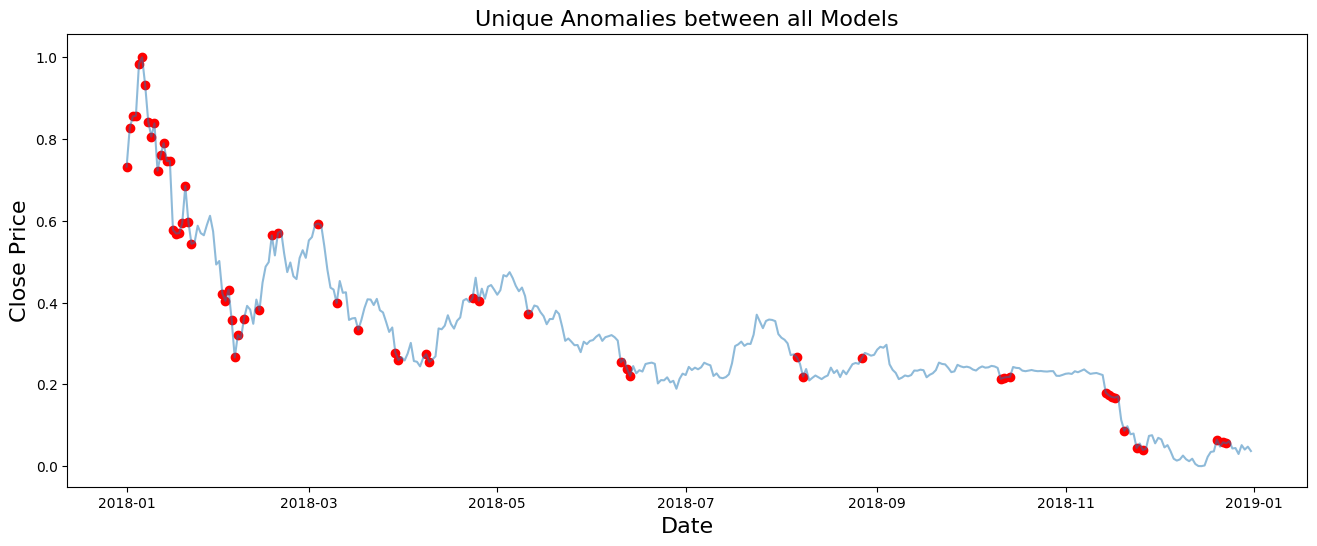

In [68]:
# filter for same dates 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import matplotlib.pyplot as plt
common = \
    set.intersection(set(X.index), set(anomalies.Date))
filter1 = X[X.index.isin(common)]
filter1 = filter1[['close']]

# Converting the index as date
X.index = pd.to_datetime(X.index)
# Alter size for the plot
plt.subplots(dpi=100,figsize=(16,6))
# plot all close price data
plt.plot(X.index, X.close,  alpha=0.5)
# set x-axis label and specific size
plt.xlabel('Date',size=16)
# set y-axis label and specific size
plt.ylabel('Close Price',size=16)
# set plot title with specific size
plt.title('Unique Anomalies between all Models',size=16)

# plot anomalies 
plt.scatter(filter1.index, filter1.close, color="red")
plt.show()

- it would be interesting to see if there are any "signals" for data identified as an anomaly right before price **spikes** or **drops**
- I would say major anomalies were flagged but some are still missing (visially) granted only 5 models were used

In [ ]:
# green color for those voted by 2 
# different colors for years 

## To Be Continued 

## Probability

In [ ]:
outlier_proba = np.transpose(pd.DataFrame(probability)).T
outlier_proba.index = X.index
#outlier_proba

## Outlier Date Counts

In [ ]:
btc_outliers = np.transpose(pd.DataFrame(df_outliers))
#btc_outliers

## Predict Rank Scores

In [ ]:
pred_rank_df = np.transpose(pd.DataFrame(predict_rank_lst))
pred_rank_df.columns = classifiers.keys()
pred_rank_df.index = merged_df.index
#pred_rank_df

# Intersection Between Merge and different datasets

In [ ]:
# number of outliers identified per method 
outlier_dates = [] # store dates here 
for col in btc_outliers.columns:
    outliers = btc_outliers[btc_outliers[col] == 1] # subset outlier data
    #df_outliers.timestamp.apply(lambda x: x.strftime('%Y-%m-%d')) # datetime to string 
    outlier_dates.append(outliers.index) # append the string/date

In [ ]:
print('Nbr of common anomalies among all models: ',len(intersection(outlier_dates[0],outlier_dates[1],outlier_dates[2],
        outlier_dates[3],outlier_dates[4],outlier_dates[5],outlier_dates[6])))

## CBLOF intersection dates across tests (arbitrary model check)

In [ ]:
[x for x in three[3] if x in prices_df[3]]

In [ ]:
def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2))

In [ ]:
# prices and blockchain
intersection(prices_df[1], block_df[1])

In [ ]:
intersection(prices_df[1], social_df[1])

In [ ]:
dates_knn = list(btc_outliers[btc_outliers['K Nearest Neighbors (KNN)']==1].index)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)  # Reduce to k=3 dimensions
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[dates_knn,0],X_reduce[dates_knn,1], X_reduce[dates_knn,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [ ]:
from pyod.models.knn import KNN

clf_name = 'KNN'
clf = KNN(contamination=0.05)
clf.fit(X.values)

In [ ]:
# predict raw anomaly score 
# np.set_printoptions(precision=None)

#clf.decision_scores_

scores_pred = clf.decision_function(X) 
print(scores_pred.shape)

In [ ]:
# get the prediction on the test data
y_pred = clf.predict(X)  # outlier labels (0 or 1)
print(y_pred.shape)
n_inliers = len(y_pred) - np.count_nonzero(y_pred)
n_outliers = np.count_nonzero(y_pred == 1)
print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
# threshold value to consider a datapoint inlier or outlier
threshold = stats.scoreatpercentile(scores_pred,100 * 0.05)
threshold